In [2]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from scipy.interpolate import make_interp_spline, BSpline

sys.path.append('/home/groups/dpwall/briannac/blood_microbiome/src/abundance')
sys.path.append('/home/groups/dpwall/briannac/general_scripts/plotting/')

from abundance_plots import MinorSymLogLocator
from pvals_distribution_plots import PlotPvals
BLOOD_MICROBIOME_DIR = '/home/groups/dpwall/briannac/blood_microbiome/'
# Files.
fig_dir=BLOOD_MICROBIOME_DIR + 'results/sex_association/'
results_dir=BLOOD_MICROBIOME_DIR + 'results/sex_association/'

bam_mappings_file  = '/home/groups/dpwall/briannac/general_data/bam_mappings.csv'
df_bacteria_file = BLOOD_MICROBIOME_DIR + 'data/bacteria_filtered.csv'
df_virus_file = BLOOD_MICROBIOME_DIR + 'data/virus_filtered.csv'

In [4]:
sys.version

'3.6.1 (default, Apr 27 2017, 10:57:56) \n[GCC 4.8.5 20150623 (Red Hat 4.8.5-11)]'

In [257]:
### Read in files.
bam_mappings = pd.read_csv(bam_mappings_file, sep='\t', index_col=1)
df_virus = pd.read_csv(df_virus_file, index_col=0)
df_virus = df_virus.drop(['Enterobacteria phage phiX174', 'Human herpesvirus 4'], axis=1)
df_virus.index = [i.split(' ')[0] for i in df_virus.index]
df_bacteria = pd.read_csv(df_bacteria_file, index_col=0)
df_bacteria.index = [i.split(' ')[0] for i in df_bacteria.index]
df_bacteria = df_bacteria.drop(['Fusobacterium ulcerans', 'Mollicutes bacterium D7'], axis=1)

# Male vs Female

## MannU Whitney

In [268]:
df_bacteria_female = df_bacteria[bam_mappings.loc[df_bacteria.index]['sex_numeric']=='2.0']
df_bacteria_male = df_bacteria[bam_mappings.loc[df_bacteria.index]['sex_numeric']=='1.0']
df_virus_female = df_virus[bam_mappings.loc[df_virus.index]['sex_numeric']=='2.0']
df_virus_male = df_virus[bam_mappings.loc[df_virus.index]['sex_numeric']=='1.0']

In [269]:
def mannwhitneyu_with_fail(x,y): 
    if (sum(x>0) + sum(y>0)) < 10: return np.nan
    return mannwhitneyu(x=x, y=y).pvalue

# Compute mann-u whitney pvals for bacteria
bacteria_pvals = np.array([mannwhitneyu_with_fail(df_bacteria_female[c].values, df_bacteria_male[c].values) for c in df_bacteria_male.columns])*len(df_bacteria)
bacteria_pvals_names = df_bacteria_female.columns[(bacteria_pvals)<.05]
bacteria_pvals = bacteria_pvals[(bacteria_pvals)<.05]

# Compute mann-u whitney pvals for bacteria
virus_pvals = np.array([mannwhitneyu_with_fail(df_virus_female[c].values, df_virus_male[c].values) for c in df_virus_male.columns])*len(df_virus)
virus_pvals_names = df_virus_female.columns[(virus_pvals)<.05]
virus_pvals = virus_pvals[(virus_pvals)<.05]

In [271]:
sex_associated_bacteria = bacteria_pvals_names
table_vals_bacteria = []
for c,p in zip(sex_associated_bacteria, bacteria_pvals):
    if mannwhitneyu(df_bacteria_female[c], df_bacteria_male[c], alternative='greater').pvalue <.05:
        table_vals_bacteria = table_vals_bacteria + [(c, '%.1f' % -np.log10(p), 'F')]
    else:
        table_vals_bacteria = table_vals_bacteria + [(c, '%.1f' % -np.log10(p), 'M')]
        
sex_associated_virus = virus_pvals_names
table_vals_virus = []
for c,p in zip(sex_associated_virus, virus_pvals):
    if mannwhitneyu(df_virus_female[c], df_virus_male[c], alternative='greater').pvalue <.05:
        table_vals_virus = table_vals_virus + [(c, '%.1f' % -np.log10(p), 'F')]
    else:
        table_vals_virus = table_vals_virus + [(c, '%.1f' % -np.log10(p), 'M')]
        
        
bacteria_sex_associated_df = pd.DataFrame(table_vals_bacteria)
virus_sex_associated_df = pd.DataFrame(table_vals_virus)
bacteria_sex_associated_df = pd.DataFrame(table_vals_bacteria)
virus_sex_associated_df = pd.DataFrame(table_vals_virus)
bacteria_sex_associated_df.columns = ['Name', 'p', 'Enriched Sex']
bacteria_sex_associated_df.index = bacteria_sex_associated_df.Name
virus_sex_associated_df.columns = ['Name', 'p', 'Enriched Sex']
virus_sex_associated_df.index = virus_sex_associated_df.Name
virus_sex_associated_df.to_csv('%s/virus_sex_associated.csv' % results_dir)

In [261]:
bacteria_sex_associated_male = bacteria_sex_associated_df[bacteria_sex_associated_df['Enriched Sex']=='M']
bacteria_sex_associated_male['species'] = [i.split(' ')[0]  for i in bacteria_sex_associated_male.Name]

bacteria_sex_associated_male['strain'] = [' '.join(i.split(' ')[1:]) for i in bacteria_sex_associated_male.Name]
def agg_func(x):
    min_x = min([float(xx) for xx in list(x)])
    max_x = max([float(xx) for xx in list(x)])
    if min_x==max_x:
        return '%.1f' % min_x
    else:
        return '%.1f-%.1f' % (min_x, max_x)
bacteria_sex_associated_male = bacteria_sex_associated_male.groupby('species')[['strain']].aggregate(lambda x: ', '.join([str(xx) for xx in list(x)])).join(
    bacteria_sex_associated_male.groupby('species')[['p']].aggregate(agg_func))
bacteria_sex_associated_male.to_csv(results_dir + 'bacteria_sex_associated_male.csv')


bacteria_sex_associated_female = bacteria_sex_associated_df[bacteria_sex_associated_df['Enriched Sex']=='F']
bacteria_sex_associated_female['species'] = [i.split(' ')[0]  for i in bacteria_sex_associated_female.Name]

bacteria_sex_associated_female['strain'] = [' '.join(i.split(' ')[1:]) for i in bacteria_sex_associated_female.Name]
def agg_func(x):
    min_x = min([float(xx) for xx in list(x)])
    max_x = max([float(xx) for xx in list(x)])
    if min_x==max_x:
        return '%.1f' % min_x
    else:
        return '%.1f-%.1f' % (min_x, max_x)
bacteria_sex_associated_female = bacteria_sex_associated_female.groupby('species')[['strain']].aggregate(lambda x: ', '.join([str(xx) for xx in list(x)])).join(
    bacteria_sex_associated_female.groupby('species')[['p']].aggregate(agg_func))
bacteria_sex_associated_female.to_csv(results_dir + 'bacteria_sex_associated_female.csv')

/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

In [262]:
top_male_virus = virus_sex_associated_df[virus_sex_associated_df['Enriched Sex']=='M'].sort_values('p', ascending=False).Name
top_female_virus = virus_sex_associated_df[virus_sex_associated_df['Enriched Sex']=='F'].sort_values('p', ascending=False).Name
top_male_bacteria = bacteria_sex_associated_df[bacteria_sex_associated_df['Enriched Sex']=='M'].sort_values('p', ascending=False).Name
top_female_bacteria = bacteria_sex_associated_df[bacteria_sex_associated_df['Enriched Sex']=='F'].sort_values('p', ascending=False).Name

In [263]:
df_bacteria['sex'] = [str(s) for s in bam_mappings.loc[df_bacteria.index]['sex_numeric']]
df_virus['sex'] = [str(s) for s in bam_mappings.loc[df_virus.index]['sex_numeric']]
df_virus = df_virus.sort_values('sex')
df_bacteria = df_bacteria.sort_values('sex')

Encephalomyocarditis virus complete


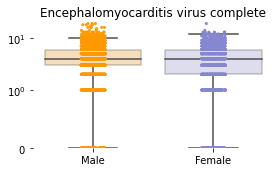

Glypta fumiferanae ichnovirus.1


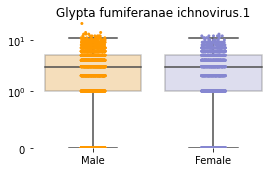

Saccharomyces cerevisiae killer


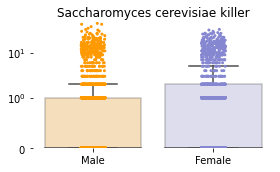

Human herpesvirus 1


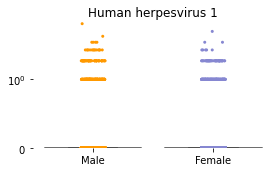

Chlorobium phaeobacteroides BS1


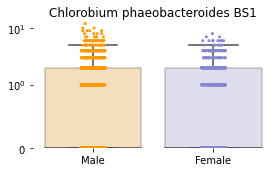

Delftia acidovorans SPH-1


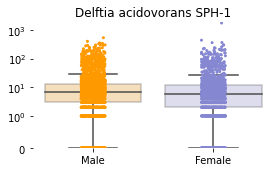

Thalassiosira pseudonana CCMP1335


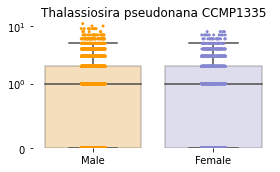

Leishmania braziliensis MHOM/BR/75/M2904


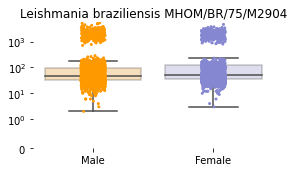

Helicobacter pylori HPKX_438_AG0C1


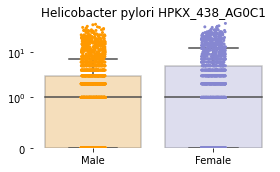

Streptomyces SPB74


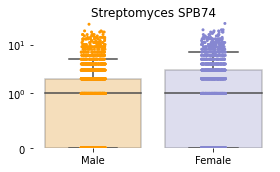

In [264]:
sns.set_palette(['#ff9900', '#8687d1'])
for i in top_male_virus.append(top_female_virus):
    print(i)
    plt.figure(figsize=(4,2.5))
    sns.stripplot(data=df_virus[[i,'sex']], y=i, x='sex', jitter=1, size=3)# hue_order=['1.0', '2.0'])
    sns.boxplot(data=df_virus[[i,'sex']], y=i, x='sex', boxprops=dict(alpha=.3), fliersize=0)
    plt.yscale('symlog', linthresh=1)
    plt.ylim(0,)
    plt.title(i)
    plt.xticks(range(2), ['Male', 'Female'])
    plt.ylabel('')
    plt.xlabel('')
    plt.tight_layout()
    plt.box(on=None)
    plt.savefig(fig_dir + i.replace(' ', '_') + '.png',
                transparent=True, bbox_inches='tight', format='png', dpi=500)
    plt.show()
    

for i in top_male_bacteria[:3].append(top_female_bacteria[:3]):
    print(i)
    plt.figure(figsize=(4,2.5))
    sns.stripplot(data=df_bacteria[[i,'sex']], y=i, x='sex', jitter=1, size=3)
    sns.boxplot(data=df_bacteria[[i,'sex']], y=i, x='sex', boxprops=dict(alpha=.3), fliersize=0)
    plt.yscale('symlog', linthresh=1)
    plt.ylim(0,)
    plt.xticks(range(2), ['Male', 'Female'])
    plt.ylabel('')
    plt.xlabel('')
    plt.title(i)
    plt.tight_layout()
    plt.box(on=None)
    plt.savefig(fig_dir + i.replace(' ', '_').replace('/', '_') + '.png',
                transparent=True, bbox_inches='tight', format='png', dpi=500)
    plt.show()


In [265]:
# Parent vs Child
if 'sex' in df_virus.columns:
    df_virus = df_virus.drop('sex', axis=1)
    df_bacteria = df_bacteria.drop('sex', axis=1)

df_bacteria_child = df_bacteria[(bam_mappings.loc[df_bacteria.index]['relationship']=='sibling')]

df_bacteria_parent = df_bacteria[(bam_mappings.loc[df_bacteria.index]['relationship']!='sibling')]


df_virus_child = df_virus[(bam_mappings.loc[df_virus.index]['relationship']=='sibling')]
df_virus_parent = df_virus[(bam_mappings.loc[df_virus.index]['relationship']!='sibling')]

# Compute mann-u whitney pvals for bacteria
bacteria_pvals = np.array([mannwhitneyu_with_fail(df_bacteria_child[c].values, df_bacteria_parent[c].values) for c in df_bacteria_parent.columns[:-1]] )*len(df_bacteria)
bacteria_pvals_names = df_bacteria_child.columns[:-1][(bacteria_pvals)<(.05)]
bacteria_pvals = bacteria_pvals[(bacteria_pvals)<(.05)]

# Compute mann-u whitney pvals for bacteria
virus_pvals = np.array([mannwhitneyu_with_fail(df_virus_child[c].values, df_virus_parent[c].values) for c in df_virus_parent.columns[:-1]] )*len(df_virus)
virus_pvals_names = df_virus_child.columns[:-1][(virus_pvals)<(.05)]
virus_pvals = virus_pvals[(virus_pvals)<(.05)]

In [266]:
print(np.percentile(df_virus_child[c], 98))
print(np.percentile(df_virus_parent[c], 98))

10.0
9.0


5.1519214925549954e-12


/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


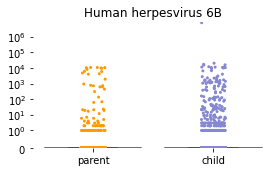

In [267]:
c = 'Human herpesvirus 6B'
print(mannwhitneyu(df_virus_parent[c], df_virus_child[c], alternative='less').pvalue)
df1 = df_virus_parent[[c]]
df1['status']='parent'
df2 = df_virus_child[[c]]
df2['status']='child'

plt.figure(figsize=(4,2.5))
sns.stripplot(data=pd.concat([df1,df2]), y=c, x='status', jitter=1, size=3)
sns.boxplot(data=pd.concat([df1,df2]), y=c, x='status', boxprops=dict(alpha=.3), fliersize=0)
plt.yscale('symlog', linthresh=1)
plt.ylim(0,)
#plt.xticks(range(2), ['Male', 'Female'])
plt.ylabel('')
plt.xlabel('')
plt.title(c)
plt.tight_layout()
plt.box(on=None)
plt.savefig(fig_dir + c.replace(' ', '_').replace('/', '_') + '.png',
              transparent=True, bbox_inches='tight', format='png', dpi=500)
plt.show()

# ASD vs NT

In [191]:
#df_virus = df_virus.drop('sex', axis=1)
#df_bacteria = df_bacteria.drop('sex', axis=1)

df_bacteria_NT = df_bacteria[(bam_mappings.loc[df_bacteria.index]['relationship']=='sibling') &
                                  pd.isna(bam_mappings.loc[df_bacteria.index]['derived_affected_status'])]

df_bacteria_ASD = df_bacteria[(bam_mappings.loc[df_bacteria.index]['relationship']=='sibling') &
                                  (bam_mappings.loc[df_bacteria.index]['derived_affected_status']=='autism')]

df_virus_NT = df_virus[(bam_mappings.loc[df_virus.index]['relationship']=='sibling') &
                                  pd.isna(bam_mappings.loc[df_virus.index]['derived_affected_status'])]
df_virus_ASD = df_virus[(bam_mappings.loc[df_virus.index]['relationship']=='sibling') &
                                  (bam_mappings.loc[df_virus.index]['derived_affected_status']=='autism')]

# Compute mann-u whitney pvals for bacteria
bacteria_pvals = np.array([mannwhitneyu_with_fail(df_bacteria_NT[c].values, df_bacteria_ASD[c].values) for c in df_bacteria_ASD.columns[:-1]] )*len(df_bacteria)
bacteria_pvals_names = df_bacteria_NT.columns[:-1][(bacteria_pvals)<(.05)]
bacteria_pvals = bacteria_pvals[(bacteria_pvals)<(.05)]

# Compute mann-u whitney pvals for bacteria
virus_pvals = np.array([mannwhitneyu_with_fail(df_virus_NT[c].values, df_virus_ASD[c].values) for c in df_virus_ASD.columns[:-1]] )*len(df_virus)
virus_pvals_names = df_virus_NT.columns[:-1][(virus_pvals)<(.05)]
virus_pvals = virus_pvals[(virus_pvals)<(.05)]

^ **No hits**